In [15]:
%load_ext autoreload
%autoreload 2

import src.ksd.models as models
from src.ksd.find_modes import find_modes, pairwise_directions, run_bfgs
from src.ksd.langevin import RandomWalkMH, RandomWalkBarker
import src.ksd.langevin as mcmc
from src.ksd.ksd import KSD, SDEKSD, GKSD
from src.ksd.kernel import IMQ, RBF
from src.ksd.bootstrap import Bootstrap
from src.ksd.find_modes import find_modes, pairwise_directions
from tqdm.notebook import tqdm, trange

import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
import matplotlib.pyplot as plt
import seaborn as sns

import src.kgof.density as density
import src.kgof.data as data

MCMCKernel = RandomWalkMH # RandomWalkBarker

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
tf.random.set_seed(1)

In [17]:
def generate_target_proposal(dim):
    ## single gaussians
    k = 1
    delta = 2.
    
    mean1 = tf.eye(dim)[:, 0] * delta
    mean2 = tf.zeros(dim)

    target = tfd.MultivariateNormalDiag(mean1)
    proposal_off = tfd.MultivariateNormalDiag(mean2)
    
    return target, proposal_off

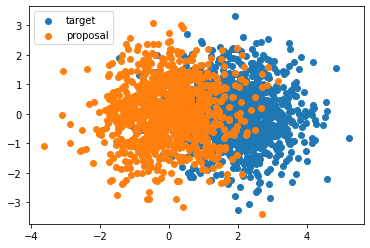

In [18]:
target, proposal = generate_target_proposal(2)
target_x = target.sample(1000)
proposal_x = proposal.sample(1000)

fig, ax = plt.subplots()
ax.scatter(target_x[:, 0], target_x[:, 1], label="target")
ax.scatter(proposal_x[:, 0], proposal_x[:, 1], label="proposal")
ax.legend()
plt.show()

In [19]:
def plot_bandwidth(dims, kernel_class, n):
    
    bandwidths = []
    for d in dims:
        print(f"dim {d}")
        _, proposal_dist = generate_target_proposal(d)
        X = proposal_dist.sample(n)
        
        kernel = kernel_class(med_heuristic=True)
        kernel.bandwidth(X, tf.identity(X))
        bandwidths.append(kernel.sigma_sq)
        
    # plot
    fig, ax = plt.subplots()
    ax.plot(dims, bandwidths, label="empirical")
    ax.plot(dims, 2 * np.array(dims), label="theoretical")
    ax.set_ylabel("Bandwidth")
    ax.set_xlabel("Dim")
    ax.legend()
    plt.show()
    
    return bandwidths

In [20]:
dims = [1, 2, 5, 10, 20, 30, 40, 50, 100]

dim 1
dim 2
dim 5
dim 10
dim 20
dim 30
dim 40
dim 50
dim 100


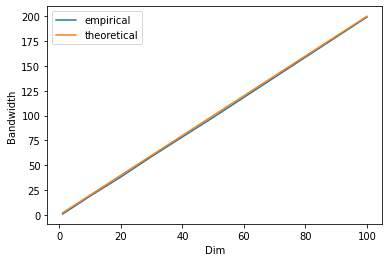

In [21]:
tf.random.set_seed(1)
bandwidths = plot_bandwidth(dims, RBF, n=1000)

In [22]:
def ksd_gaussians(d, bandwidth=None):
    if not bandwidth:
        bandwidth = 2 * d
    
    delta = 2.
    mean1 = tf.eye(d)[:, 0] * delta
    mean1_norm_sq = np.sum(mean1**2)
    
#     res = (np.pi/2)**(d / 2) * bandwidth**d / (bandwidth+2)**(d/2) * mean1_norm_sq
#     res = bandwidth**d / (bandwidth**2 + 4*bandwidth + 8)**(d/2) * mean1_norm_sq
    res = (bandwidth / (bandwidth + 4))**(d/2) * mean1_norm_sq
    
    return res

In [48]:
def plot_ksd(dims, kernel_class, n):
    
    ksd_empirical_list = []
    ksd_theoretical_list = []
    bandwidth_list = []
    for d in dims:
        print(f"dim: {d}")
        target, proposal_dist = generate_target_proposal(d)
        X = proposal_dist.sample(n)
        
        # compute ksd empirically
#         kernel = kernel_class(med_heuristic=True)
#         kernel = kernel_class(sigma_sq=1.)
#         kernel = kernel_class(sigma_sq=d*2.) # med-heuristic
        kernel = kernel_class(sigma_sq=2*d**0.5) # under-estimated
#         kernel = kernel_class(sigma_sq=2*d**1.5) # over-estimated

        ksd = KSD(kernel=kernel, log_prob=target.log_prob)
        ksd_val = ksd(X, tf.identity(X))
        
        ksd_empirical_list.append(ksd_val)
        
        # compute ksd from theoretical formula
        ksd_theoretical_list.append(ksd_gaussians(d, bandwidth=kernel.sigma_sq))
        
        # store bandwidths
        bandwidth_list.append(kernel.sigma_sq)
        
    fig, ax = plt.subplots()
    ax.plot(dims, ksd_empirical_list, label="empirical")
    ax.plot(dims, ksd_theoretical_list, label="theoretical")
    ax.set_ylabel("KSD")
    ax.set_xlabel("Dim")
    ax.legend()
    
    return ksd_empirical_list, ksd_theoretical_list, bandwidth_list

dim: 1
dim: 2
dim: 5
dim: 10
dim: 20
dim: 30
dim: 40
dim: 50
dim: 60


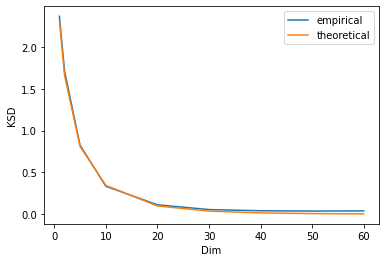

In [49]:
tf.random.set_seed(1)
dims = [1, 2, 5, 10, 20, 30, 40, 50, 60]
ksd_empirical_list, ksd_theoretical_list, bandwidth_list = plot_ksd(dims, RBF, n=2000)

In [42]:
bandwidth_list

[2, 8, 50, 200, 800, 1800, 3200, 5000, 7200]

In [43]:
ksd_empirical_list

[<tf.Tensor: shape=(), dtype=float32, numpy=2.3654947>,
 <tf.Tensor: shape=(), dtype=float32, numpy=2.746803>,
 <tf.Tensor: shape=(), dtype=float32, numpy=3.275751>,
 <tf.Tensor: shape=(), dtype=float32, numpy=3.5354016>,
 <tf.Tensor: shape=(), dtype=float32, numpy=3.747097>,
 <tf.Tensor: shape=(), dtype=float32, numpy=3.87506>,
 <tf.Tensor: shape=(), dtype=float32, numpy=4.001246>,
 <tf.Tensor: shape=(), dtype=float32, numpy=3.861834>,
 <tf.Tensor: shape=(), dtype=float32, numpy=4.0523615>]

In [44]:
# ksd_theoretical_list = []
# for d in dims:
#     ksd_theoretical_list.append(ksd_gaussians(d, bandwidth=1))

ksd_theoretical_list

[2.309401076758503,
 2.6666666666666665,
 3.299898657919672,
 3.622923239319663,
 3.805391762784276,
 3.86900748391771,
 3.901300554708451,
 3.92082604299121,
 3.9339040210203904]

Text(0.5, 0, 'Dim')

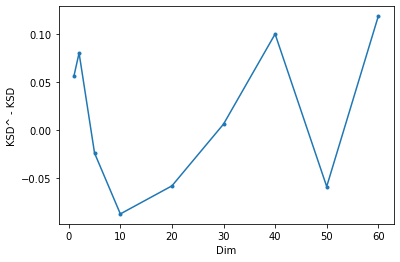

In [45]:
fig, ax = plt.subplots()
ax.plot(dims, np.array(ksd_empirical_list) - np.array(ksd_theoretical_list), marker=".")
ax.set_ylabel("KSD^ - KSD")
ax.set_xlabel("Dim")